In [156]:
import torch
import time
from utils.utils import generate_mask, load_model, writeDACFile
from dataloader.dataset import onehot, getNumClasses
from utils.utils import interpolate_vectors

import os
import yaml

from DACTransformer.DACTransformer import TransformerDecoder
from DACTransformer.CondQueryTransformer import ClassConditionedTransformer
from DACTransformer.CondKeyTransformer import ClassConditionedKeyTransformer
from DACTransformer.PostNormCondDACTransformer import PostNormCondDACTransformerDecoder

import numpy as np
import matplotlib.pyplot as plt


morphs between infsnd1[i] and infsnd2[i] (and back). If the sounds are the same, then the only thing that interpolates is the paramdeter value Otherwise both the class and the parameter value interpolate.

In [157]:
### params
experiment_name = "01.20PostNormCond_2_" 
checkpoint_dir = 'runs' + '/' + experiment_name
cptnum =  600 #params['num_epochs'] # 300 #(must be in the checkpoint directory)

# will morph between infsnd1[i] and infsnd2[i] (and back)
infsnd1 = ['pistons', 'wind', 'applause', 'bees'] # used for inference
#infsnd2 = ['pistons' , 'wind',   'applause', 'bees'] # used for inference
infsnd2 = ['applause', 'bees', 'pistons', 'wind' ] # used for inference

# Load YAML file
with open(checkpoint_dir + '/' + 'params.yaml', 'r') as file:
    params = yaml.safe_load(file)
    
TransformerClass =  globals().get(params['TransformerClass'])  
print(f"using TransformerClass = {params['TransformerClass']}") 
print(f' and TransformerClass is class object {TransformerClass}')

cond_size = 8 # num_classes + num params - not a FREE parameter!

embed_size = params['tblock_input_size'] -cond_size # 240 #32  # embed_size must be divisible by num_heads and by num tokens
print(f'embed_size is {embed_size}')


fnamebase='out' + '.e' + str(params['tblock_input_size']-cond_size) + '.l' + str(params['num_layers']) + '.h' + str(params['num_heads']) + '_chkpt_' + str(cptnum).zfill(4) 
checkpoint_path = checkpoint_dir + '/' +  fnamebase  + '.pth' 

# for saving sound 
outdir=checkpoint_dir

DEVICE='cpu' #####################################################''cuda'

inference_steps=86*20  #86 frames per second


# Values for interpolating the parameter value (start at minpval, up to maxpval, and then back)
minpval=0
maxpval=1
topn=1024 # sample from the top n logits


print(f'checkpoint_path = {checkpoint_path}, fnamebase = {fnamebase}' )

using TransformerClass = PostNormCondDACTransformerDecoder
 and TransformerClass is class object <class 'DACTransformer.PostNormCondDACTransformer.PostNormCondDACTransformerDecoder'>
embed_size is 504
checkpoint_path = runs/01.20PostNormCond_2_/out.e504.l2.h8_chkpt_0600.pth, fnamebase = out.e504.l2.h8_chkpt_0600


In [158]:
if DEVICE == 'cuda' :
    torch.cuda.device_count()
    torch.cuda.get_device_properties(0).total_memory/1e9

    device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
    torch.cuda.device_count()
    print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
else :
    device=DEVICE
device

'cpu'

In [159]:
def sample_top_n(logits, n):
    """
    Select top `n` logits for each token, apply softmax, and sample token indices.
    
    Args:
        logits (torch.Tensor): Tensor of shape (batch_size, 1, num_tokens, vocab_size)
        n (int): Number of top logits to consider per token.
        
    Returns:
        torch.Tensor: Tensor of sampled token indices with shape (batch_size, num_tokens)
    """
    # Ensure the input tensor shape is (batch_size, num_tokens, vocab_size)
    batch_size, num_tokens, vocab_size = logits.shape

    # Find the top n logits and their indices along the vocabulary dimension
    top_n_logits, top_n_indices = torch.topk(logits, n, dim=-1)  # Shape: (batch_size, 1, num_tokens, n)

    # Apply softmax to the top n logits
    top_n_probs = torch.softmax(top_n_logits, dim=-1)  # Shape: (batch_size, 1, num_tokens, n)

    # Sample from the top n probabilities for each token
    sampled_indices = torch.multinomial(top_n_probs.view(-1, n), 1).squeeze(-1)  # Shape: (batch_size * num_tokens)

    # Map the sampled indices back to the original vocabulary indices
    sampled_vocab_indices = top_n_indices.view(-1, n).gather(1, sampled_indices.unsqueeze(-1)).squeeze(-1)
    
    # Reshape back to (batch_size, num_tokens)
    sampled_vocab_indices = sampled_vocab_indices.view(batch_size, num_tokens)

    return sampled_vocab_indices



In [160]:
def inference(model, inference_cond, Ti, vocab_size, num_tokens, inference_steps, fname) :
    model.eval()
    mask = generate_mask(Ti, Ti).to(device)
    input_data = torch.randint(0, vocab_size, (1, Ti, num_tokens)).to(device)  # Smaller context window for inference
    predictions = []

    t0 = time.time()
    for i in range(inference_steps):  # 
        if cond_size == 0:
            output = model(input_data, None, mask) # step through 
        else : 
            output = model(input_data, inference_cond[:, i:Ti+i, :], mask) # step through

        # This takes the last vector of the sequence (the new predicted token stack) so has size(b,steps,4,1024)
        # This it takes the max across the last dimension (scores for each element of the vocabulary (for each of the 4 tokens))
        # .max returns a duple of tensors, the first are the max vals (one for each token) and the second are the
        #        indices in the range of the vocabulary size. 
        # THAT IS, the 4 selected "best" tokens (one for each codebook) are taken independently
        ########################### next_token = output[:, -1, :, :].max(-1)[1]  # Greedy decoding for simplicity
        next_token = sample_top_n(output[:, -1, :, :],2) # top 1 would be the same as max in the comment line above
            
        #print(f'next_token: {next_token} which had a top 1 logit value of {sample_top_n(output[:, -1, :, :],1)}')
        #print(f'                                       and a had a top 2 logit value of {sample_top_n(output[:, -1, :, :],2)}')
                                                                           
                                                                           
        
        predictions.append(next_token)
        input_data = torch.cat([input_data, next_token.unsqueeze(1)], dim=1)[:, 1:]  # Slide window

    t1 = time.time()
    inf_time = t1-t0
    print(f'inference time for {inference_steps} steps, or {inference_steps/86} seconds of sound is {inf_time}' )

    dacseq = torch.cat(predictions, dim=0).unsqueeze(0).transpose(1, 2)
    if mask == None:
        writeDACFile(fname + '_unmasked', dacseq)
    else :
        writeDACFile(fname, dacseq)       

In [161]:
print(f' About to call load_model with TransformerClass = {TransformerClass}')
model, Ti, vocab_size, num_codebooks, cond_size = load_model(checkpoint_path,  TransformerClass, DEVICE)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')


model.to(device);


 About to call load_model with TransformerClass = <class 'DACTransformer.PostNormCondDACTransformer.PostNormCondDACTransformerDecoder'>
Setting up MultiEmbedding with vocab_size= 1024, embed_size= 504, num_codebooks= 4
Setting up RotaryPositionalEmbedding with embed_size= 504, max_len= 430
Total number of parameters: 9211168


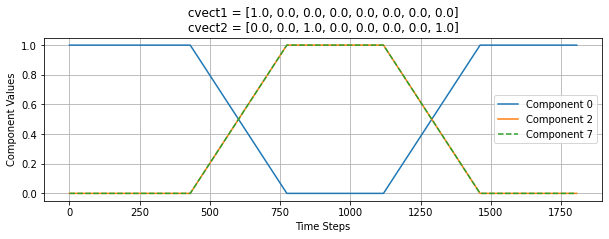

shape of inf_cond is  = torch.Size([1, 1807, 8])
outfname is runs/01.20PostNormCond_2_/dacs/pistons.applause_chkpt_0600_steps_1720.minpval_0.00.maxpval_1.00.topn_1024
inference time for 1720 steps, or 20.0 seconds of sound is 9.353393793106079


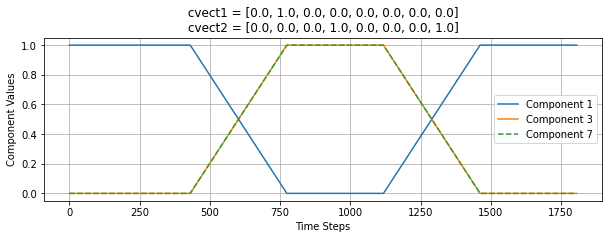

shape of inf_cond is  = torch.Size([1, 1807, 8])
outfname is runs/01.20PostNormCond_2_/dacs/wind.bees_chkpt_0600_steps_1720.minpval_0.00.maxpval_1.00.topn_1024
inference time for 1720 steps, or 20.0 seconds of sound is 6.615478754043579


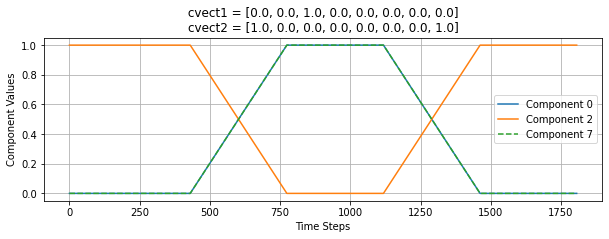

shape of inf_cond is  = torch.Size([1, 1807, 8])
outfname is runs/01.20PostNormCond_2_/dacs/applause.pistons_chkpt_0600_steps_1720.minpval_0.00.maxpval_1.00.topn_1024
inference time for 1720 steps, or 20.0 seconds of sound is 7.915859699249268


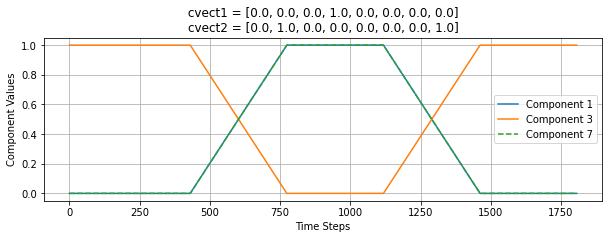

shape of inf_cond is  = torch.Size([1, 1807, 8])
outfname is runs/01.20PostNormCond_2_/dacs/bees.wind_chkpt_0600_steps_1720.minpval_0.00.maxpval_1.00.topn_1024
inference time for 1720 steps, or 20.0 seconds of sound is 6.634729385375977
Done


In [162]:

for snum in range(len(infsnd1)) : 
    if cond_size == 0 :
        inference_cond = None
    else : 
        one_hot_fvector1=onehot(infsnd1[snum]) #The parameter evolution over time will be the same for all sounds
        one_hot_fvector2=onehot(infsnd2[snum]) #The parameter evolution over time will be the same for all sounds

        cvect1=torch.cat((one_hot_fvector1, torch.tensor([minpval])))
        cvect2=torch.cat((one_hot_fvector2, torch.tensor([maxpval])))

        steps=[0,Ti+1*inference_steps//5, Ti+2*inference_steps//5, Ti+3*inference_steps//5, Ti+4*inference_steps//5, Ti+inference_steps]
        inference_cond=interpolate_vectors([cvect1,cvect1, cvect2, cvect2, cvect1, cvect1 ], steps) #length must cover staring context window+inf steps

        # Extract the 2D array of shape [n, m]
        data = inference_cond[0]

        # Find components that change over time
        changing_indices = [i for i in range(cond_size) if not torch.all(data[:, i] == data[0, i])]

        # Format the arrays as strings
        cvect1_str = ', '.join(map(str, cvect1.tolist()))
        cvect2_str = ', '.join(map(str, cvect2.tolist()))

        # Plot the changing components
        plt.figure(figsize=(10, 3))

        for i in changing_indices:
            if i != 7 :
                plt.plot(data[:, i], label=f'Component {i}')
            else : 
                plt.plot(data[:, i], label=f'Component {i}', linestyle='--')

        plt.xlabel('Time Steps')
        plt.ylabel('Component Values')
        plt.title(f' cvect1 = [{cvect1_str}] \ncvect2 = [{cvect2_str}]')
        plt.legend()
        plt.grid(True)
        plt.show()

        inference_cond=inference_cond.to(device)
        print(f'shape of inf_cond is  = {inference_cond.shape}') 

        
        outfname=outdir+"/"+ "dacs" + "/" +  infsnd1[snum] + "." + infsnd2[snum] + '_chkpt_' + str(cptnum).zfill(4) +  "_steps_"+str(inference_steps).zfill(4)+'.minpval_'+ f"{minpval:01.2f}" +'.maxpval_'+ f"{maxpval:01.2f}" +'.topn_'+ f"{topn:04d}"
        print(f'outfname is {outfname}')
        inference(model, inference_cond, Ti, vocab_size, num_codebooks, inference_steps, outfname ) 

print('Done')